# The image slurper
Are you **tired** of asking people for the data behind their published false color plots? Use the image slurper to reconstruct the underlying matrix of values from a false-color (heat map) image and its colorbar! 

The slurper can be used on many types of false color plots, and works best on relatively smooth data.

In [1]:
%reset -f
%run imageslurper.py

As an example, here is a typical pseudoprojection plot of NASA brightness temperature data and a corresponding colorbar. This plot is not ideal as the ocean appears to be uniformly set to the lowest value which generates sharp gradients along coastlines.

![title](img/world-temp.jpg)

Next, run the following cell and use the mouse to draw boxes around the plot area and around the colorbar area in the cell output:

<IPython.core.display.Javascript object>


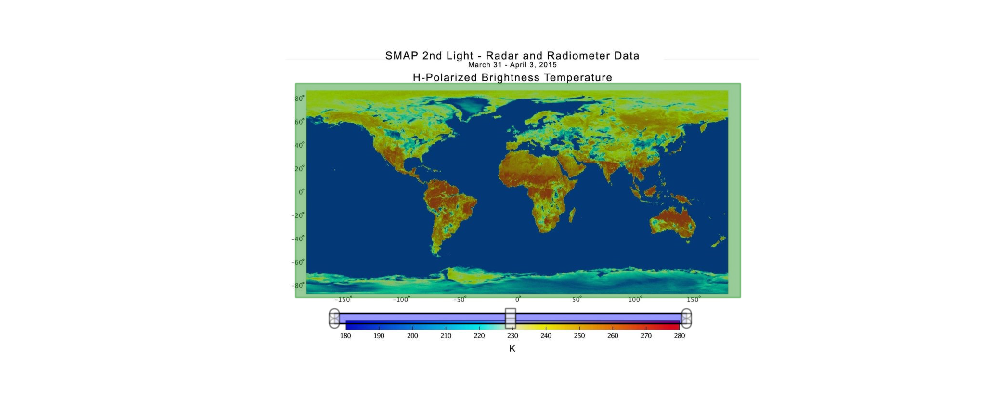

In [2]:
file = "img/world-temp.jpg"
full_image = PIL.Image.open(file)

%matplotlib notebook

fig, current_ax = plt.subplots(figsize=(10,4))
current_ax.imshow(full_image)
current_ax.axis('off')

boxes = [Rectangle((1, 1), 0, 0, facecolor='green', edgecolor='green', alpha=0.4),
         Rectangle((1, 1), 0, 0, facecolor='blue', edgecolor='blue', alpha=0.4)]

current_ax.add_patch(boxes[0])
current_ax.add_patch(boxes[1])


count=0
numbox=len(boxes)
def line_select_callback(eclick, erelease):
    global count
    'eclick and erelease are the press and release events'
    x1, y1 = eclick.xdata, eclick.ydata
    x2, y2 = erelease.xdata, erelease.ydata

    bid = count % numbox
    boxes[bid].set_x(x1)
    boxes[bid].set_y(y1)
    boxes[bid].set_width(x2-x1)
    boxes[bid].set_height(y2-y1)
    
    count += 1

RS1 = RectangleSelector(current_ax, line_select_callback,
                                       drawtype='box', useblit=True,
                                       button=[1],  # don't use middle button
                                       minspanx=5, minspany=5,
                                       spancoords='pixels',
                                       interactive=True,
                                       rectprops=dict(facecolor='none', edgecolor = 'black',
                                                      alpha=1, fill=True))

plt.show()

If tick marks extend into the colorbar, try to avoid that region. The mouse interactions loosely crop out the map area  and the colorbar by specifying `map_corners` and `bar_corners`. The two areas can overlap but the map area must not contain any part of the colorbar, or vice versa. The values can also be given by hand below.

In [3]:
%matplotlib inline

map_corners = [(m.x0, m.y0, m.x1, m.y1) for m in (boxes[0].get_bbox(),)][0]
bar_corners = [(m.x0, m.y0, m.x1, m.y1) for m in (boxes[1].get_bbox(),)][0]

print("Map corners: ", map_corners)
print("Colorbar corners:", bar_corners)

Map corners:  (59.90909090909099, 71.99999999999989, 984.5844155844154, 516.6753246753246)
Colorbar corners: (140.948051948052, 549.922077922078, 872.3766233766232, 570.7012987012988)


The notebook should now isolate the map area and the colorbar from the rest of the image. The reconstruction uses a horizontal colorbar, accomplished by the `rotate` method if necessary. The lowest value should be on the left. 

'Map'

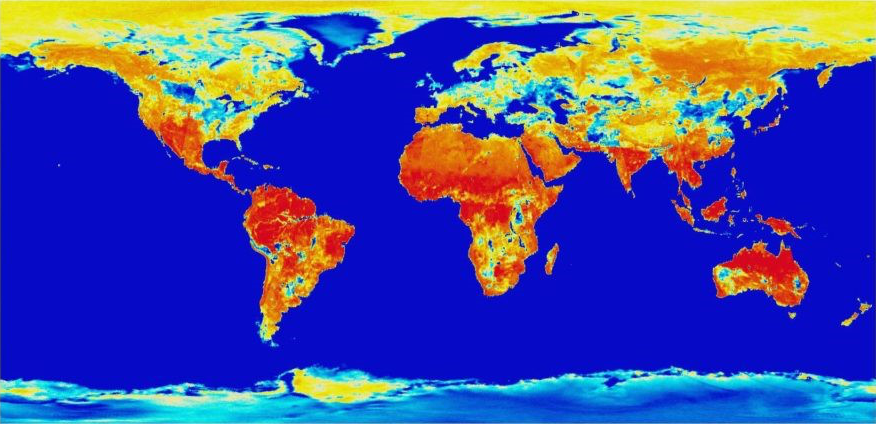

'Colorbar'

In [4]:
map_image = full_image.crop(map_corners)
colorbar_img = full_image.crop(bar_corners).rotate(0, expand=True)

map_image = crop(map_image, thresh=80)
colorbar_img = crop(colorbar_img, thresh=100)

display('Map', map_image, 'Colorbar', colorbar_img)

Resize the image to make the processing faster (optional).

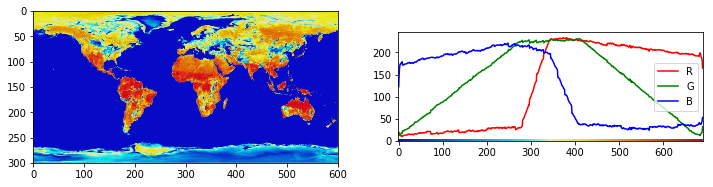

In [5]:
new_dimensions = 600, 300
image = map_image.resize(new_dimensions, PIL.Image.LANCZOS)
rgb_img = np.array(image)

assert not np.any(np.isnan(rgb_img)), "No NaN values allowed."

fig, axs = plt.subplots(1,2, figsize=(12,8))
axs[0].imshow(rgb_img)

colorbar_img = np.array(colorbar_img)
colorbar_rgb = np.average(colorbar_img, axis=0)

assert not np.any(np.isnan(colorbar_img)), "No NaN values allowed."

ax = axs[1]
ax.imshow(colorbar_img)
for _id, color in enumerate('rgb'):
    ax.plot(colorbar_rgb[..., _id], color=color)
ax.invert_yaxis()
plt.legend('RGB')
plt.show()

The reconstruction alogrithm uses brute force and picks the nearest color in the colormap for each pixel and assigns a value in the range $[0,1]$. The error is also in the range $[0,1]$.

644.0 0.3333333333333286


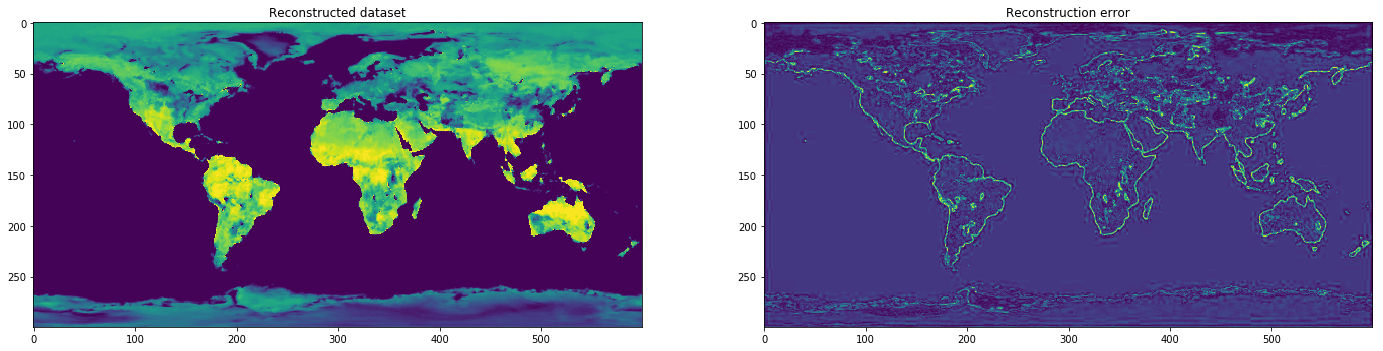

In [6]:
# See https://stackoverflow.com/questions/43843381/digitize-a-colormap
def unmap_nearest(img, rgb):
    """ img is an image of shape [n, m, 3], and rgb is a colormap of shape [k, 3]. """
    d = np.sum(np.abs(img[np.newaxis, ...] - rgb[:, np.newaxis, np.newaxis, :]), axis=-1)    
    i = np.argmin(d, axis=0)
    err = np.min(d, axis=0)
    print(np.max(d), np.min(d))
    return i / (rgb.shape[0] - 1), err / (255*3)

reconstructed, err = unmap_nearest(rgb_img, colorbar_rgb)

assert not np.any(np.isnan(reconstructed)), "No NaN values allowed."
assert not np.any(np.isnan(err)), "No NaN values allowed."

fig, axs = plt.subplots(1, 2, figsize=(24,12))
ax = axs[0]
img = ax.imshow(reconstructed, cmap='viridis')
ax.set_title('Reconstructed dataset')

ax = axs[1]
ax.set_title('Reconstruction error')
img = ax.imshow(err, cmap='viridis')

Remove the tick marks; in areas where the error is larger than `thresh` replace the value by the median of its neighbours. Set the threshold value as low as possible to capture the tick marks extending into the plot area, but not the interior of the plot.

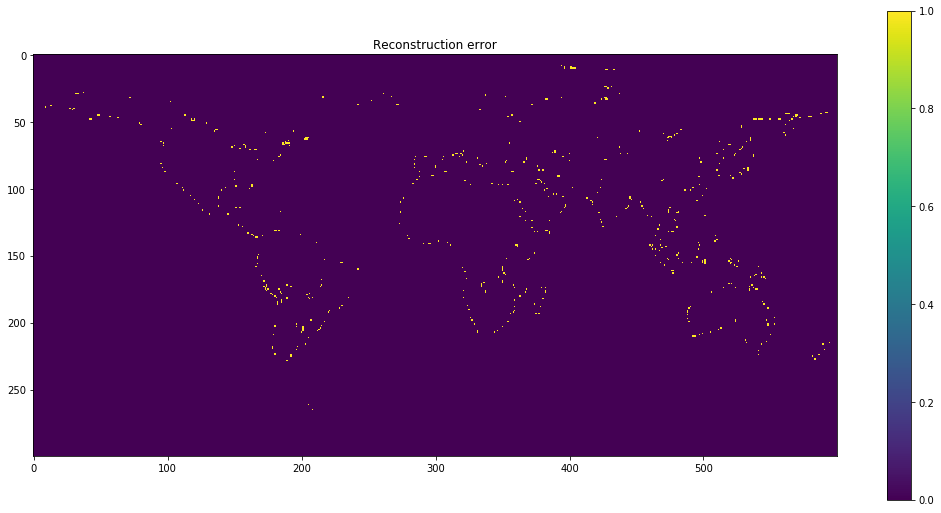

In [7]:
error_threshold=.20

fig, ax = plt.subplots(1, 1, figsize=(18,9))
ax.set_title('Reconstruction error')
img = ax.imshow(1.0 * (err > error_threshold), cmap='viridis')
fig.colorbar(img, ax=ax)

In [8]:
def hole_fill(data, error, di=5, thresh=.02):

    data_padded = np.empty([i+2*di for i in data.shape])
    data_padded.fill(np.nan)

    data_padded[di:-di, di:-di] = reconstructed
    data_padded[di:-di, di:-di][error>thresh]=np.nan

    result = data
    ids = np.where(error>thresh)
    ids = np.array(ids)
    for x_id, y_id in ids.T:
        x_id+=di
        y_id+=di

        result[x_id-di, y_id-di] = np.nanmedian(data_padded[x_id-di:x_id+di, y_id-di:y_id+di])

    return result

filled = hole_fill(reconstructed, err, thresh=error_threshold)

Scale the image to the expected by setting `vmin` and `vmax` to the values indicated on the colorbar. 

In [9]:
vmin, vmax = 180, 280
filled = filled * (vmax - vmin) + vmin

Plot the reconstructed map with the original colormap. The images should be very similar.

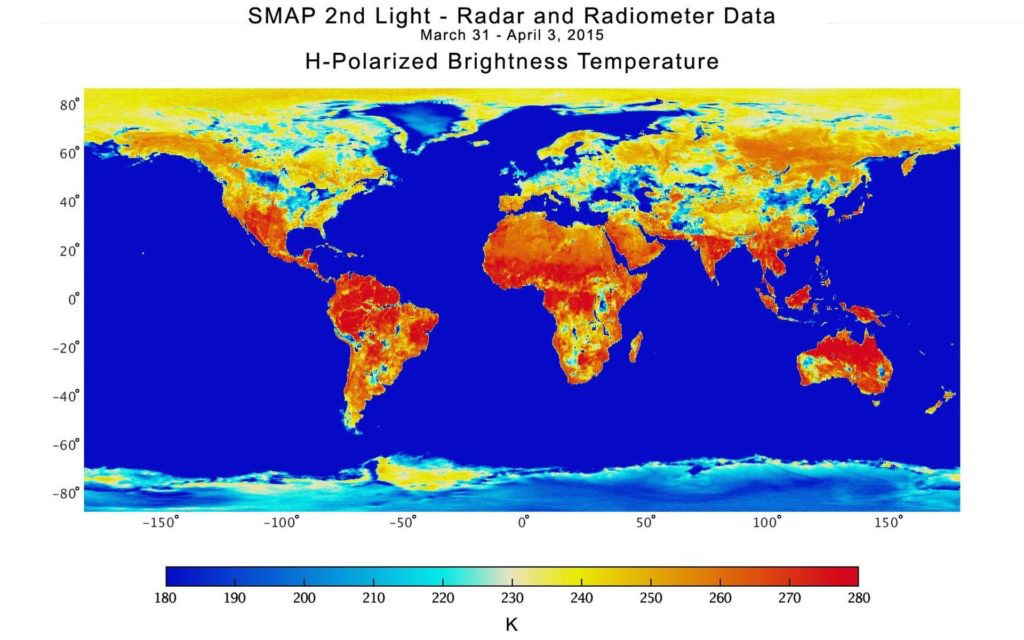

Image values range: [180.000000, 280.000000]


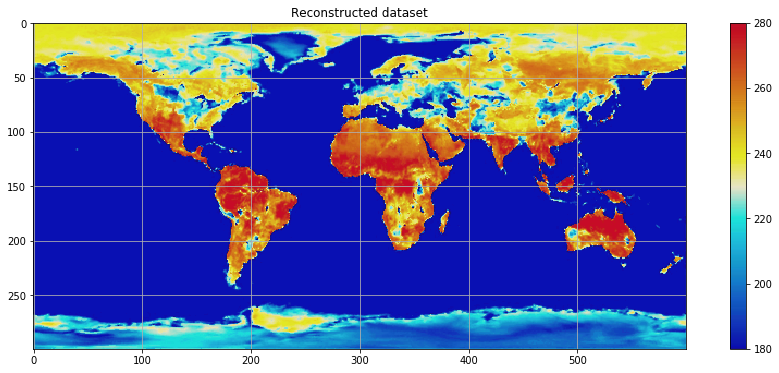

In [10]:
IPython.display.display(full_image)

if np.any(np.isnan(filled)):
    print("Some NaN values could not be filled.")

fig, ax = plt.subplots(figsize=(16,6))
original_colormap = ListedColormap(colorbar_rgb/255)
img = ax.imshow(filled, cmap=original_colormap, vmin=vmin, vmax=vmax)
print("Image values range: [%f, %f]" % (filled.min(), filled.max()))
ax.grid(True)
fig.colorbar(img)
plt.title('Reconstructed dataset')

    
plt.savefig(basename(file) + ".reconstructed.png")

plt.show()

Save the image and the colorbar RGB values in a `pickle` file.

In [11]:
save_file = basename(file) + "-slurped.p"
with open(save_file, 'wb') as save_handle:
    pickle.dump([filled, colorbar_rgb],
                save_handle,
                protocol=pickle.HIGHEST_PROTOCOL)

# This reads the objects back:
with open(save_file, 'rb') as load_handle:
    filled, colorbar_rgb = pickle.load(load_handle)

Or save the image as a `csv` file

In [12]:
np.savetxt(basename(file) + "-slurped.csv", 
              filled, 
              delimiter=", ",
              fmt="%0.6e",
              header=make_header(file, filled.shape))